# Assignment — Epidemic models

In [1]:
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from zlib import adler32
import networkx as nx
import numpy as np

### Task 1. Euler method (0 points)

Euler method is a simple numerical procedure for solving ordinary differential equations (ODEs) with a given initial values.  For example, if we want to solve an equation

$$dx/dt = \sin(x)$$

with initial value $x = x_0$, we can subtitute $dx = \Delta x = x_{i+1} - x_{i}$ and $dt = \Delta t$, therefore we obtain

$$\frac{x_{i+1} - x_i}{\Delta t} = \sin(x)$$ 
$$x_{i+1} = x_i + \sin(x)\Delta t$$

Let $\Delta t = 0.1$, and then we can solve the equation using this iterative form as follows

In [2]:
def solve_sinx(x0, dt, k):
    x = x0
    solution = [x0]
    for _ in range(k):
        dx = np.sin(x) * dt
        x = x + dx
        solution.append(x)
    return solution

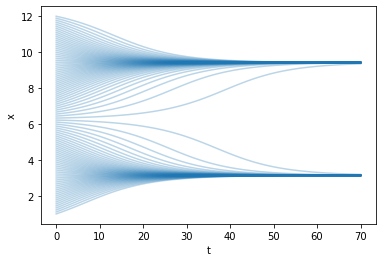

In [3]:
dt = 0.1
for x0 in np.linspace(1, 12, 100):
    solution = solve_sinx(x0, dt, 70)
    plt.plot(solution, c='tab:blue', alpha=0.3);
plt.xlabel('t')
plt.ylabel('x')
plt.show()

Assume that we want to solve the famous chaotic Lorenz System:

$$
\begin{cases}
\frac{dx}{dt} = \sigma(y-x)\\
\frac{dy}{dt} = x(\rho - z) - y\\
\frac{dz}{dt} = xy - \beta z\\
\end{cases}
$$

with parameters $\rho = 28$, $\sigma = 10$, $\beta = 8/3$ and initial values $x = y = z = 10$.

Write a function `lorenz` that takes initial values, parameters, time increment `dt`, number of iterations `k` and returns np.array with solution of the form `[[x0, y0, z0], [x1, y1, z1], ...]` so that number of rows is `k+1`.

In [4]:
def lorenz(x0, y0, z0, rho, sigma, beta, dt, k):
    # YOUR CODE HERE
    x = x0
    y = y0
    z = z0
    solution = [[x0, y0, z0]]
    for _ in range(k):
      dx = dt * sigma * (y - x)
      dy = dt * (x * (rho - z) - y)
      dz = dt * (x * y - beta * z)
      x = dx + x
      y = dy + y
      z = dz + z
      solution.append([x, y, z])
    return np.array(solution)

In [5]:
sim = lorenz(10., 10., 10., 28., 10., 8/3, 0.01, 8000-1)
assert sim.shape == (8000, 3)
assert np.all(sim[0] == [10, 10, 10])
assert np.all(sim[1].round(2) == [10., 11.7, 10.73])
assert np.all(sim[2].round(2) == [10.17, 13.31, 11.62])
assert adler32(str(sim[3].round(2)[0]).encode()) == 48496892

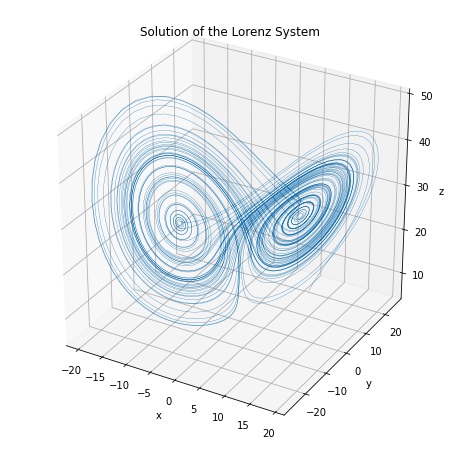

In [6]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
xs, ys, zs = sim[:, 0], sim[:, 1], sim[:, 2]
ax.plot(xs, ys, zs, lw=0.3)
plt.title('Solution of the Lorenz System')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

### Task 2. SI model (0 points)

Consider a simple model of an epidemic — SI model. S — susceptible, I — infectious. Initialy we only have a few infected persons and all others are susceptible. Then some susceptible people become infected with infection rate $\beta$. The model is defined as follows:

Dynamic form

$$S \underset{\beta \frac{S}{N}I}{\to} I$$

Equation form

$$\frac{dI}{dt} = \beta \frac{S}{N}I$$

$$S + I = N$$

where $N$ is the total population.

Write a function `si_epidemic` that takes the total population `total`, number of infected people `I0`, infected rate `beta`, time increment `dt`, number of iterations `k` and returns a returns np.array with solution of the form `[[S0, I0], [S1, I1], ...]` so that number of rows is k+1.

In [7]:
def si_epidemic(total, I0, beta, dt, k):
    # YOUR CODE HERE
    S0 = total - I0
    s = S0
    i = I0
    solution = [[S0, I0]]
    for _ in range(k):
      i = i * (beta * s / total * dt + 1)
      s = total - i
      solution.append([s, i])
    return np.array(solution)

In [8]:
solution = si_epidemic(total=1000, I0=1, beta=0.3, dt=0.5, k=130-1)
assert solution.shape == (130, 2)
assert np.all(solution[0] == [999, 1])
assert np.all(solution[10].round(2) == [995.97, 4.03])
assert np.all(solution[-1].round(2) == [0, 1000])
assert adler32(str(solution[100].round(2)[0]).encode()) == 32047304

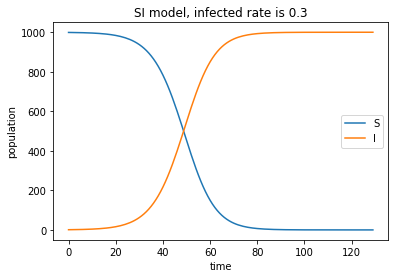

In [9]:
plt.plot(solution)
plt.legend(['S', 'I'])
plt.title('SI model, infected rate is 0.3')
plt.xlabel('time')
plt.ylabel('population')
plt.show()

Let us look at the plot of epidemic dynamics with the same setup but $\beta = 0.1$.

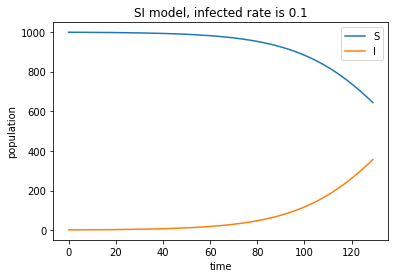

In [10]:
solution = si_epidemic(total=1000, I0=1, beta=0.1, dt=0.5, k=130-1)
plt.plot(solution)
plt.legend(['S', 'I'])
plt.title('SI model, infected rate is 0.1')
plt.xlabel('time')
plt.ylabel('population')
plt.show()

### Task 3. SIR model (0 points)

The next model is SIR. S — susceptible, I — infectious, R — recovered people. Initialy we only have a few infected persons and others are susceptible. Then some susceptible people become infected with infection rate $\beta$ and some infected people recover with recovery rate $\gamma$. There is no chance to infect after recovering. The model is defined as follows:

Dynamic form

$$S \underset{\beta SI}{\to} I \underset{\gamma I}{\to} R$$

Equation form (in proportions of the population)

$$\begin{cases}
ds/dt = -\beta si\\
di/dt = \beta si - \gamma i\\
dr/dt = \gamma i\\
s+i+r = 1
\end{cases}$$

Write a function `sir_epidemic` that takes an initial proportion `s0`, `i0`, `r0`, infection rate `beta`, recovery rate `gamma`, a number of steps `k` and time increment `dt`. The function returns np.array of shape `(k+1, 3)` with `s`, `i`, `r` proportion in each step. The first row contains an initial proportion.

In [11]:
def sir_epidemic(s0, i0, r0, beta, gamma, k, dt):
    # YOUR CODE HERE
    solution = [[s0, i0, r0]]
    s = s0
    i = i0
    r = r0
    for _ in range(k):
        ds = - beta * s * i * dt
        di = (beta * s * i - gamma * i) * dt
        dr = gamma * i * dt
        s = s + ds
        i = i + di
        r = r + dr
        solution.append([s, i, r])
    return np.array(solution)

In [12]:
s0, i0, r0 = 0.99, 0.01, 0
beta, gamma = 0.6, 0.1
dt = 1
epidemic = sir_epidemic(s0, i0, r0, beta, gamma, 80, dt)
assert epidemic.shape == (81, 3)
assert np.all(epidemic[0] == [0.99, 0.01, 0.  ])
assert np.all(epidemic[5].round(2) == [0.92, 0.07, 0.01])
assert np.all(epidemic[80].round(2) == [0, 0, 1])
assert adler32(str(epidemic[10].round(2)[1]).encode()) == 32112840

Here is also the critical point for a basic reproduction number $R_0 = \beta / \gamma$

* If $R_0 > 1$: Endemic State,  $r(+\infty) \to 1$
* If $R_0 < 1$: Disease-free State, $r(+\infty) \to \text{const}$

where $r(t)$ is the share of recovered people at the time moment $t$.

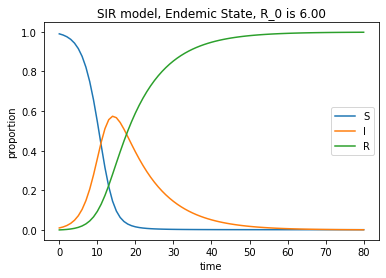

In [13]:
plt.plot(epidemic)
plt.legend(['S', 'I', 'R']);
plt.title('SIR model, Endemic State, R_0 is {:.2f}'.format(beta/gamma))
plt.xlabel('time')
plt.ylabel('proportion')
plt.show()

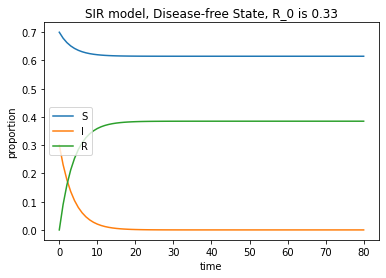

In [14]:
s0, i0, r0 = 0.7, 0.3, 0.
dt = 1
beta, gamma = 0.1, 0.3
epidemic = sir_epidemic(s0, i0, r0, beta, gamma, 80, dt)
plt.plot(epidemic)
plt.legend(['S', 'I', 'R']);
plt.title('SIR model, Disease-free State, R_0 is {:.2f}'.format(beta/gamma))
plt.xlabel('time')
plt.ylabel('proportion')
plt.show()

### Task 4. Fitting SIR model (2 points)

Let us numerically estimate parameters of SIR model. First of all, implement SIR model. You can copy-paste it from the SIR model task.

In [15]:
def sir_epidemic(s0, i0, r0, beta, gamma, k, dt):
    # YOUR CODE HERE
    solution = [[s0, i0, r0]]
    s = s0
    i = i0
    r = r0
    for _ in range(k):
        ds = - beta * s * i * dt
        di = (beta * s * i - gamma * i) * dt
        dr = gamma * i * dt
        s = s + ds
        i = i + di
        r = r + dr
        solution.append([s, i, r])
    return np.array(solution)

In the current task we will define two functions: `sir_error` and `fit_sir`. The first one estimates the RMSE error between real data and SIR model. The second one minimizes the error and returns the best parameters `beta` and `gamma` for SIR model.

Write a function `sir_error` that takes SIR parameters and the data of the form `[[s0, i0, r0], [s1, i1, r2], ...]`. It returns RMSE error between I in the data and I from the model. Initial values of SIR are first values in the data.

In [16]:
from sklearn.metrics import mean_squared_error as mse
def sir_error(beta, gamma, dt, data):
    # YOUR CODE HERE
    model = sir_epidemic(data[0][0], data[0][1], data[0][2], beta, gamma, data.shape[0]-1, dt)
    return np.sqrt(mse(data[:, 1], model[:, 1]))

In [17]:
data = np.array([
    [0.999, 0.001, 0.000],
    [0.996, 0.002, 0.002],
    [0.990, 0.004, 0.006],
])
assert round(sir_error(beta=0.3, gamma=0.2, dt=1, data=data), 4) == 0.0017
assert round(sir_error(beta=0.3, gamma=0.2, dt=0.1, data=data), 4) == 0.0018

Write a function `fit_sir` that takes the data of the form `[[s0, i0, r0], [s1, i1, r2], ...]`, dt and initial SIR parameters `beta0` and `gamma0`. It fit parameters minimizing `sir_error` and returns the best beta and gamma. You can use any available numerical optmizers such as L-BFGS-B in `scipy.optimize.minimize`.

In [18]:
from scipy.optimize import minimize
def fit_sir(data, dt, beta0, gamma0):
    # YOUR CODE HERE
    f = lambda x: sir_error(x[0], x[1], dt, data)
    res = minimize(f, x0=(beta0, gamma0), method='Nelder-Mead', tol=0.000000001)
    return res.x

In [19]:
dt = 0.5
data = sir_epidemic(s0=0.99, i0=0.01, r0=0.00, beta=0.7, gamma=0.1, k=100, dt=dt)
beta, gamma = fit_sir(data[:10], dt=dt, beta0=0.001, gamma0=0.001)
assert sir_error(beta, gamma, dt, data) < 0.00001

Now let us simulate an epidemic with some noise and see how the epidemic forecasting changes with respect to the length of train period.

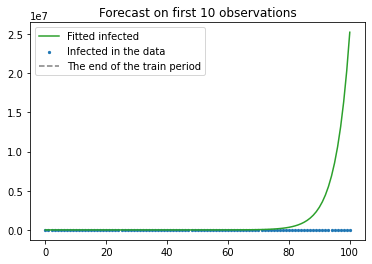

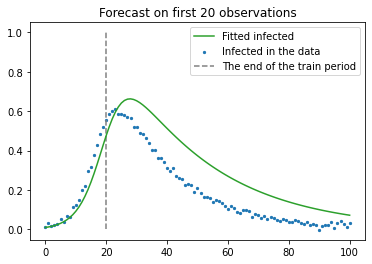

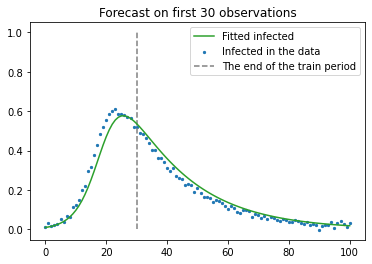

In [20]:
np.random.seed(0)
dt = 0.5
data = sir_epidemic(s0=0.99, i0=0.01, r0=0.00, beta=0.7, gamma=0.1, k=100, dt=dt)
data = data + np.random.randn(*data.shape) * 0.01
for train_len in [10, 20, 30]:
    beta, gamma = fit_sir(data[:train_len], dt=dt, beta0=0.001, gamma0=0.001)
    fitted_sir = sir_epidemic(s0=0.99, i0=0.01, r0=0.00, beta=beta, gamma=gamma, k=100, dt=dt)
    plt.scatter(np.arange(data.shape[0]), data[:, 1], s=5, label='Infected in the data')
    plt.plot(fitted_sir[:, 1], label='Fitted infected', color='tab:green')
    plt.vlines(train_len, 0, 1, linestyles='--', color='gray', label='The end of the train period')
    plt.legend()
    plt.title(f'Forecast on first {train_len} observations')
    plt.show()

### Task 5. SIS on networks (0 points)

Let us consider epidemic models on networks. SIS model is described by a dynamic form

$$S \to_{\beta SI} I \to_{\gamma I} S$$

To model epidemics on networks, we need to use probabilistic approach. First, let us define a function that gives us a random sample of available nodes by given probability.

Here is a function `select_nodes` that takes a np.array `vec`, where an i-th element is a number of neighbors that can affect to i-th node with probability `proba`. For example, `vec` can represent the number of infected neighbors, say [0, 2, 1] and then the probability is an infected rate $\beta$. That means the first node has no infected neighbors, the second has two infected neighbors, the third has one infected neighbor. Thereby, the second node has a $(1 - (1-\beta)^2)$ probability of getting infected.

In [21]:
def select_nodes(vec, proba):
    sample = np.random.rand(len(vec))
    res = sample < (1 - (1 - proba)**vec)
    return res.astype('int')

Let us infect a few random nodes and simulate a propogation of an epidemic.

Write a function `sis_networks` that takes a graph `G`, np.array with an initial indicator vector `S` where `S[i]` is 1 if i-th node is susceptible and 0 otherwise (the same for `I`). Any node must be susceptible or infected at any step. Also the function takes rates `beta`, `gamma`, number of steps `k`. The function returns a np.array of shape `(k+1, 2, n)` where `n` is a number of nodes. At i-th step, the matrix `result[i, :, :]` contains indicator `S` in the first column and `I` in the second.

_Hint: to calculate the number of infected neighbors, use `I @ A * S`_

In [22]:
def sis_networks(G, S, I, beta, gamma, k):
    # YOUR CODE HERE
    A = nx.to_numpy_array(G)
    solution = [[S, I]]
    for _ in range(k):
      dI = select_nodes(I @ A * S, beta) - select_nodes(I, gamma)
      I = I + dI
      S = 1 - I
      solution.append([S, I])
    return np.array(solution)

In [23]:
G = nx.barabasi_albert_graph(30, 2, seed=0)

I = np.zeros(len(G))
I[:3] = 1
S = 1 - I
beta = 0.2
gamma = 0.2

epidemic = sis_networks(G, S, I, beta, gamma, 100)
assert epidemic.sum() == 3030
assert epidemic.shape == (101, 2, 30)
assert (epidemic.sum(axis=1) == 1).sum() == 3030
assert 8.2271 < round(epidemic.sum(axis=2)[:, 0].mean(), 4) < 15.8452
assert 14.2177 < round(epidemic.sum(axis=2)[:, 1].mean(), 4) < 21.7279

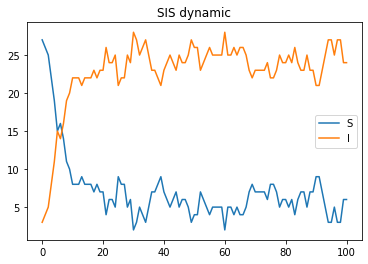

In [24]:
epidemic = sis_networks(
    G, S, I, beta=0.1, gamma=0.05, k=100)
plt.plot(epidemic.sum(axis=2))
plt.title('SIS dynamic')
plt.legend(['S', 'I']);

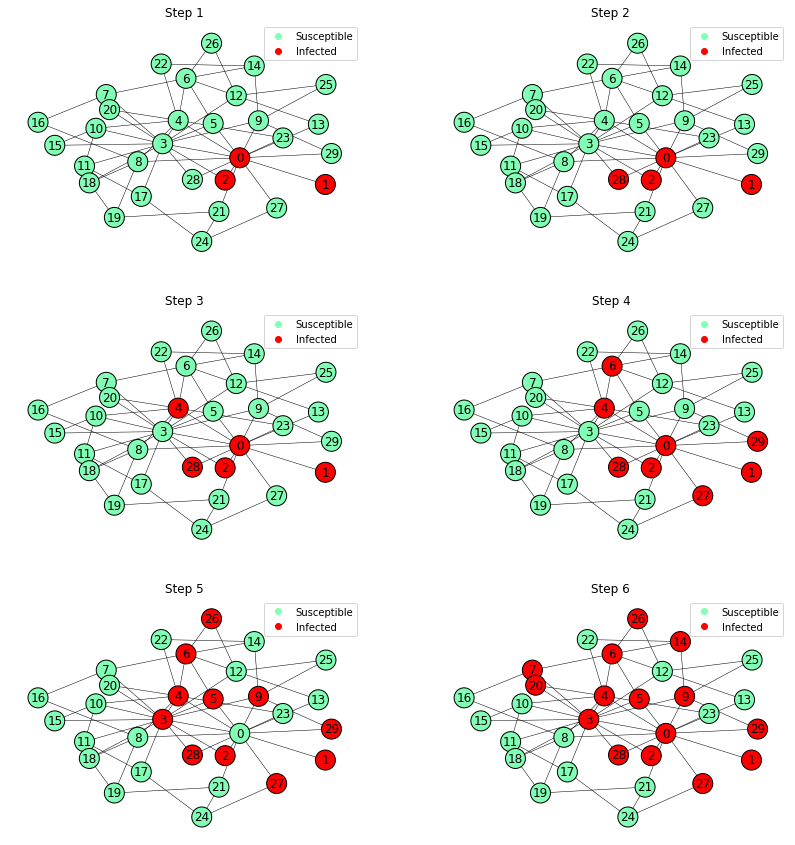

In [25]:
plt.figure(figsize=(7*2, 5*3))
pos = nx.kamada_kawai_layout(G)
i = 1
for S, I in epidemic[:6]:
    plt.subplot(3, 2, i)
    nodes = nx.draw_networkx_nodes(G, pos, 
            node_size=400,
            node_color=I+1, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    nx.draw_networkx_edges(G, pos,
            width=0.5,
            node_size=400)
    nx.draw_networkx_labels(G, pos)
    plt.title('Step {}'.format(i))
    plt.legend(nodes.legend_elements()[0], ['Susceptible', 'Infected'])
    plt.axis('off')
    i += 1

### Task 6. SIRS on networks (2 points)

Let us implement SIRS node-level model
$$S \to_{\beta SI} I \to_{\gamma I} R \to_{\delta R} S$$

Write a function `sirs_networks` that takes a graph `G`, np.array with initial indicator `S` where `S[i]` is 1 if i-th node is susceptible and 0 otherwise (the same for `I` and `R`). Also the function takes rates `beta`, `gamma`, `delta`, number of steps `k`. The function returns a np.array of shape `(k+1, 3, n)` where `n` is a number of nodes. At i-th step, the matrix `result[i, :, :]` contains indicator `S` in the first column, `I` in the second, `R` in the third.

In [26]:
def sirs_networks(G, S, I, R, beta, gamma, delta, k):
    # YOUR CODE HERE
    A = nx.to_numpy_array(G)
    solution = [[S, I, R]]
    for _ in range(k):
      dI = select_nodes(I @ A * S, beta)
      dR = select_nodes(I, gamma)
      dS = select_nodes(R, delta)
      I = I + dI - dR
      R = R + dR - dS
      S = 1 - I - R
      solution.append([S, I, R])
    return np.array(solution)

In [27]:
G = nx.barabasi_albert_graph(30, 2, seed=0)
I = np.zeros(len(G))
I[:3] = 1
S = 1 - I
R = np.zeros(len(G))

epidemic = sirs_networks(G, S, I, R, beta=0.1, gamma=0.05, delta=0.01, k=1000)
assert epidemic.shape == (1001, 3, 30)
assert (epidemic.sum(axis=1) == 1).sum() == 1001 * 30
assert np.all(epidemic[0].sum(axis=1) == (27, 3, 0))
assert np.all(epidemic[-1].sum(axis=1) == (30, 0, 0))
assert epidemic[0:20, 2].sum() > 0

for k in range(6):
    for node in G.nodes:
        if epidemic[k, 0, node] > epidemic[k+1, 0, node]:
            assert epidemic[k+1, 1, node] == 1
            neighbors = np.array([n for n in G.neighbors(node)])
            assert epidemic[k, 1][neighbors].sum()
        elif epidemic[k, 1, node] > epidemic[k+1, 1, node]:
            assert epidemic[k+1, 2, node] == 1
        elif epidemic[k, 2, node] > epidemic[k+1, 2, node]:
            assert epidemic[k+1, 0, node] == 1

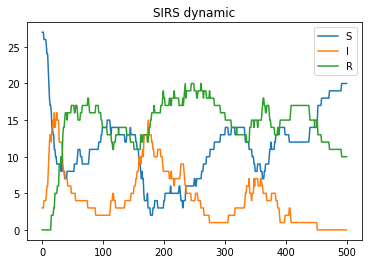

In [28]:
epidemic = sirs_networks(
    G, S, I, R, beta=0.05, gamma=0.03, delta=0.01, k=500)
plt.plot(epidemic.sum(axis=2))
plt.title('SIRS dynamic')
plt.legend(['S', 'I', 'R']);

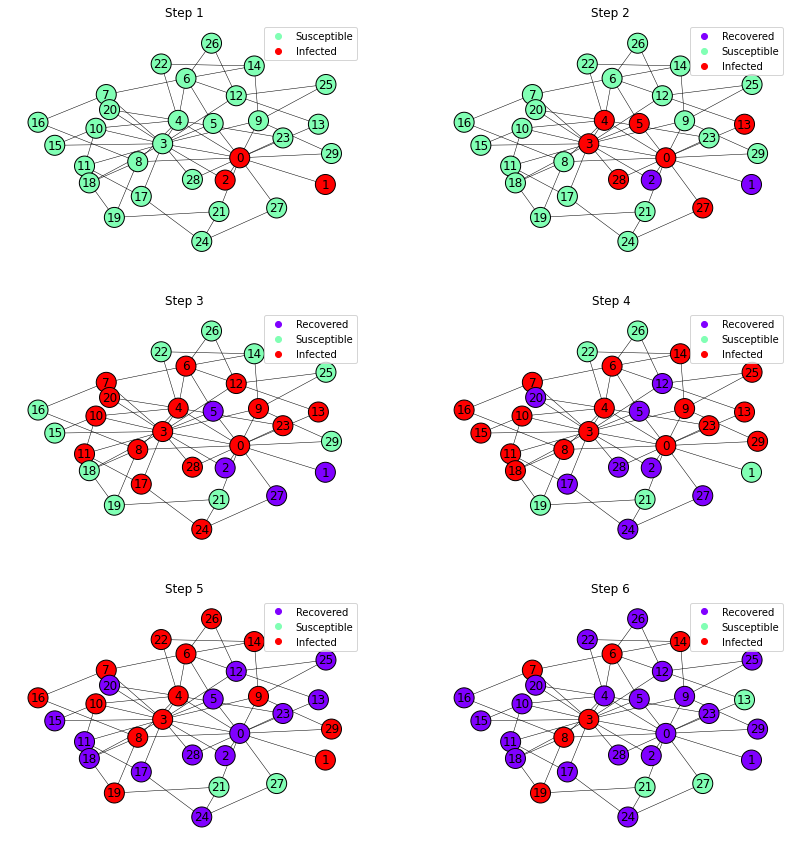

In [29]:
epidemic = sirs_networks(
    G, S, I, R, beta=0.5, gamma=0.3, delta=0.1, k=6)
plt.figure(figsize=(7*2, 5*3))
pos = nx.kamada_kawai_layout(G)
i = 1
for S, I, R in epidemic[:6]:
    plt.subplot(3, 2, i)
    nodes = nx.draw_networkx_nodes(G, pos, 
            node_size=400,
            node_color=(S + I*2), 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    nx.draw_networkx_edges(G, pos,
            width=0.5,
            node_size=400)
    nx.draw_networkx_labels(G, pos)
    plt.title('Step {}'.format(i))
    if len(nodes.legend_elements()[0]) == 2:
        plt.legend(
            nodes.legend_elements()[0], 
            ['Susceptible', 'Infected'])
    else:
        plt.legend(
            nodes.legend_elements()[0], 
            ['Recovered', 'Susceptible', 'Infected'])
    plt.axis('off')
    i += 1

### Task 7. Random immunization in SIS (2 points)

Immunization strategies specify how vaccines, treatments or drugs are distributed in the population. Ideally, should a treatment or vaccine exist, it should be given to every infected individual or those at risk of contracting the pathogen. However, it is costly to vaccinate all risky people. Given these constraints, immunization strategies aim to minimize the threat of a pandemic by most effectively distributing the available vaccines or treatments. Let us see how different vaccination strategies affect epidemics under SIS model on netwoks.

Random immunization in the network means isolation of randomly selected nodes, that is removing all their adjacent edges. Write a function `random_immunization_sis` that takes the share of immunized nodes `share`, parameters of SIS model and returns a tuple:
* list of immune nodes
* SIS model output

Do not change the input graph.

In [30]:
def random_immunization_sis(G, S, I, share, beta, gamma, k):
    # YOUR CODE HERE
    list_of_immune = np.random.choice(G.nodes, size=int(np.floor(len(G.nodes)*share)))
    G_ = G.copy()
    for immune in list_of_immune:
      for edge in G_.edges:
        if immune in edge:
          G_.remove_edge(*edge)
    output = sis_networks(G_, S, I, beta, gamma, k)
    return list_of_immune, output

In [31]:
G = nx.barabasi_albert_graph(30, 2, seed=0)
I = np.zeros(len(G))
I[:5] = 1
S = 1 - I
immune_nodes, epidemic = random_immunization_sis(
    G, S, I, share=1.0, beta=0.2, gamma=0.1, k=1)
assert G.number_of_edges() == 56
assert immune_nodes.shape[0] == 30
immune_nodes, epidemic = random_immunization_sis(
    G, S, I, share=0.0, beta=0.2, gamma=0.1, k=1)
assert immune_nodes.shape[0] == 0
unique_nodes = set()
for _ in range(100):
    immune_nodes, epidemic = random_immunization_sis(
        G, S, I, share=0.1, beta=0.2, gamma=0.1, k=1)
    unique_nodes = unique_nodes.union(immune_nodes)
assert len(unique_nodes) == 30
G = nx.complete_graph(4)
I = np.array([1, 0, 0, 0])
S = 1 - I
n_infected = []
for _ in range(100):
    immune_nodes, epidemic = random_immunization_sis(
        G, S, I, share=0.25, beta=1.0, gamma=0.0, k=1)
    if 0 in immune_nodes:
        assert epidemic[-1, 1].sum() == 1
    else:
        assert epidemic[-1, 1].sum() == 3

Let us see how the random immunization works on networks.

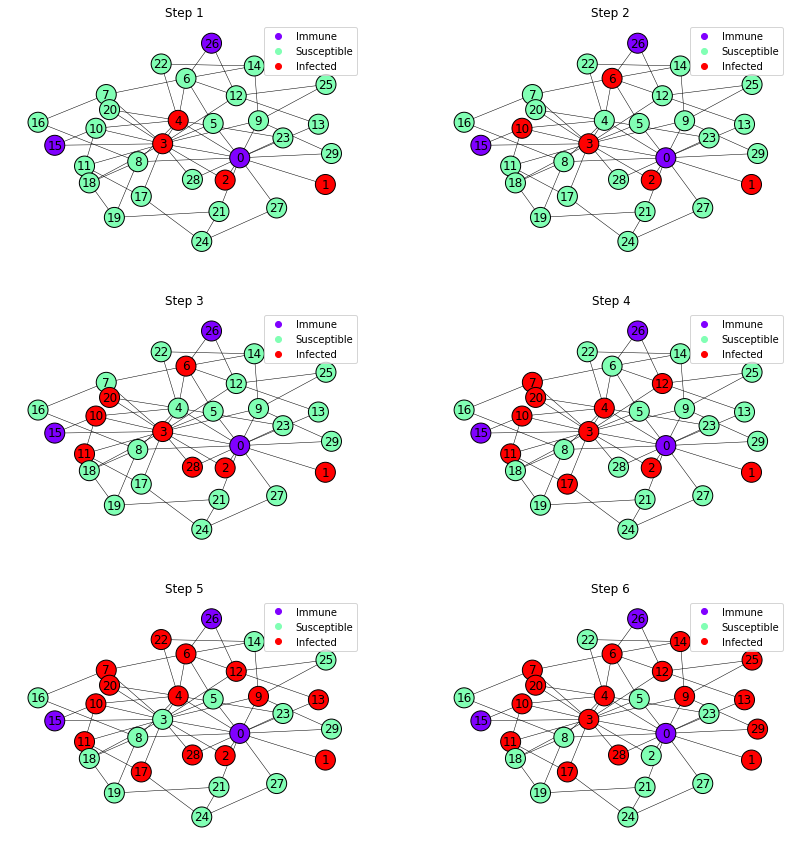

In [32]:
G = nx.barabasi_albert_graph(30, 2, seed=0)
I = np.zeros(len(G))
I[:5] = 1
S = 1 - I
immune_nodes, epidemic = random_immunization_sis(
    G, S, I, share=0.1, beta=0.2, gamma=0.1, k=6)
plt.figure(figsize=(7*2, 5*3))
pos = nx.kamada_kawai_layout(G)
i = 1
for S_i, I_i in epidemic[:6]:
    colors = I_i + 1
    colors[immune_nodes] = -1
    plt.subplot(3, 2, i)
    nodes = nx.draw_networkx_nodes(G, pos, 
            node_size=400,
            node_color=colors, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    nx.draw_networkx_edges(G, pos,
            width=0.5,
            node_size=400)
    nx.draw_networkx_labels(G, pos)
    plt.title('Step {}'.format(i))
    plt.legend(nodes.legend_elements()[0], ['Immune', 'Susceptible', 'Infected'])
    plt.axis('off')
    i += 1

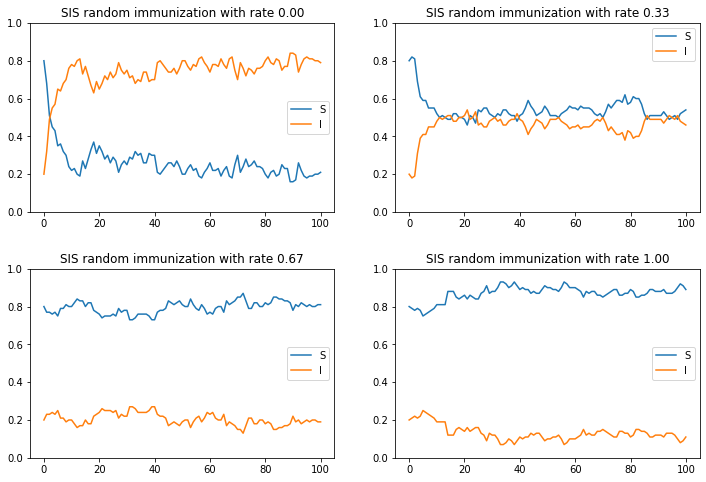

In [33]:
plt.figure(figsize=(6*2, 4*2))
plt.subplots_adjust(hspace=0.3)
G = nx.barabasi_albert_graph(100, 2, seed=0)
I = np.zeros(len(G))
I[:20] = 1
S = 1 - I
i = 1
for share in np.linspace(0, 1, 4):
    plt.subplot(2, 2, i)
    i += 1
    immune, epidemic = random_immunization_sis(
        G, S, I, share, beta=0.15, gamma=0.1, k=100)
    plt.plot(epidemic.mean(axis=2))
    plt.title(f"SIS random immunization with rate {share:.2f}")
    plt.legend(['S', 'I'])
    plt.ylim(0, 1)

### Task 8. Selective immunization in SIS (2 points)

Selective immunization is a strategy to select some important nodes to be vaccinated. Let they be nodes with highest degree.

Selective immunization in the network means isolation of highest degree nodes, that is removing all their adjacent edges. Write a function `selective_immunization_sis` that takes the share of immunized nodes `share`, parameters of SIS model and returns a tuple:
* list of immune nodes
* SIS model output

Do not change the input graph.

In [34]:
def selective_immunization_sis(G, S, I, share, beta, gamma, k):
    # YOUR CODE HERE
    degrees = {node: val for node, val in G.degree()}
    degree_sorted = np.array(sorted(degrees.items(), key=lambda item: item[1], reverse=True))
    list_of_immune = degree_sorted[: int(np.floor(degree_sorted.shape[0] * share)), 0]
    G_ = G.copy()
    for immune in list_of_immune:
      for edge in G_.edges:
        if immune in edge:
          G_.remove_edge(*edge)
    output = sis_networks(G_, S, I, beta, gamma, k)
    return list_of_immune, output

In [35]:
G = nx.barabasi_albert_graph(30, 2, seed=0)
I = np.zeros(len(G))
I[:5] = 1
S = 1 - I
immune_nodes, epidemic = selective_immunization_sis(
    G, S, I, share=0.5, beta=0.2, gamma=0.1, k=1)
assert G.number_of_edges() == 56
assert immune_nodes.shape[0] == 15
assert np.sum(sorted(nx.to_numpy_array(G).sum(axis=1), reverse=True)[:15]) \
    == nx.to_numpy_array(G)[immune_nodes].sum()

Let us see how the selective immunization works on networks.

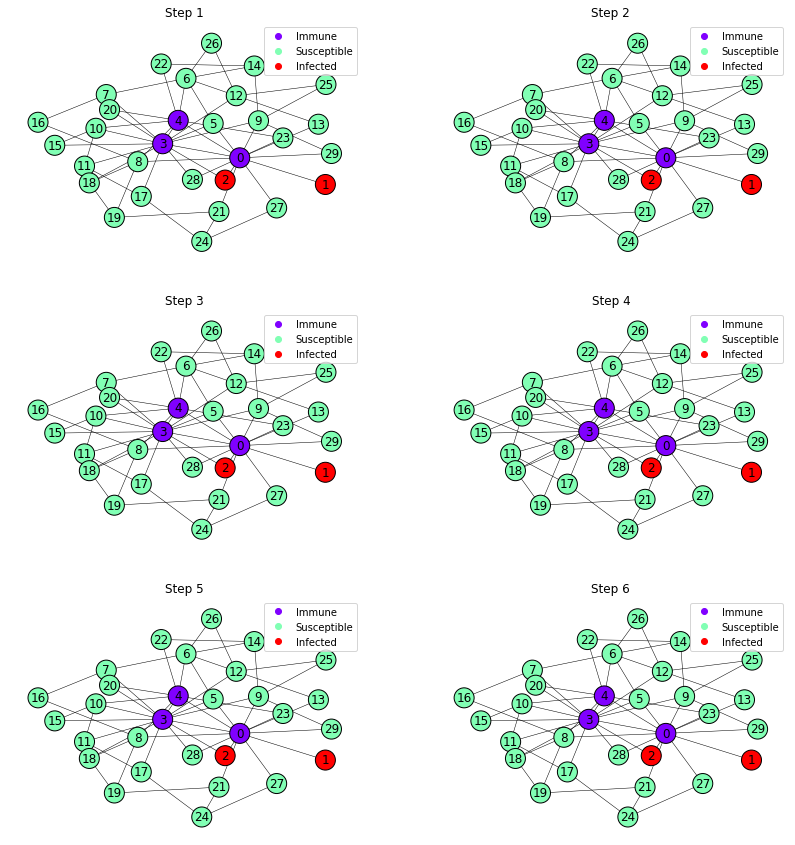

In [36]:
G = nx.barabasi_albert_graph(30, 2, seed=0)
I = np.zeros(len(G))
I[:5] = 1
S = 1 - I
immune_nodes, epidemic = selective_immunization_sis(
    G, S, I, share=0.1, beta=0.2, gamma=0.1, k=6)
plt.figure(figsize=(7*2, 5*3))
pos = nx.kamada_kawai_layout(G)
i = 1
for S_i, I_i in epidemic[:6]:
    colors = I_i + 1
    colors[immune_nodes] = -1
    plt.subplot(3, 2, i)
    nodes = nx.draw_networkx_nodes(G, pos, 
            node_size=400,
            node_color=colors, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    nx.draw_networkx_edges(G, pos,
            width=0.5,
            node_size=400)
    nx.draw_networkx_labels(G, pos)
    plt.title('Step {}'.format(i))
    plt.legend(nodes.legend_elements()[0], ['Immune', 'Susceptible', 'Infected'])
    plt.axis('off')
    i += 1

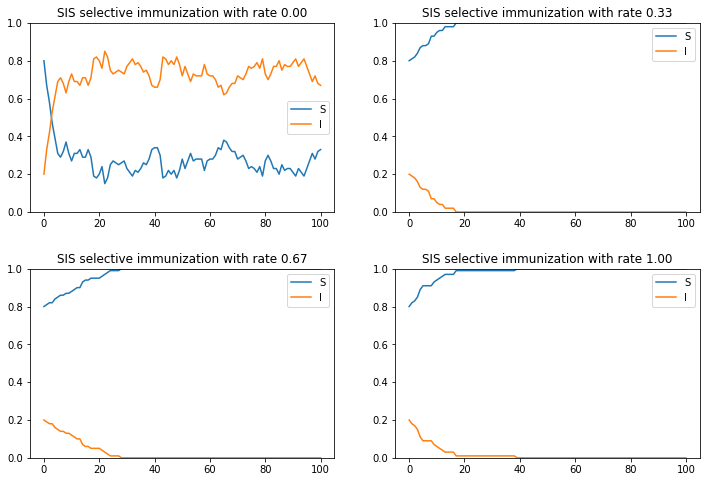

In [37]:
plt.figure(figsize=(6*2, 4*2))
plt.subplots_adjust(hspace=0.3)
G = nx.barabasi_albert_graph(100, 2, seed=0)
I = np.zeros(len(G))
I[:20] = 1
S = 1 - I
i = 1
for share in np.linspace(0, 1, 4):
    plt.subplot(2, 2, i)
    i += 1
    immune, epidemic = selective_immunization_sis(
        G, S, I, share, beta=0.15, gamma=0.1, k=100)
    plt.plot(epidemic.mean(axis=2))
    plt.title(f"SIS selective immunization with rate {share:.2f}")
    plt.legend(['S', 'I'])
    plt.ylim(0, 1)

### Task 9. Self-isolation strategy in SIS (2 points)

Self-isolation is close to the random immunization — we make some individuals invisible to the virus for a period.

Self-isolation in the network means isolation of some random nodes, that is removing all their adjacent edges for a period and then recover deleted edges. Write a function `self_isolation_sis` that takes the share of nodes `share`, period of self-isolation `period`, parameters of SIS model and returns a tuple:
* list of self-isolated nodes
* SIS model output

Do not change the input graph.

In [38]:
def self_isolation_sis(G, S, I, share, period, beta, gamma, k):
    # YOUR CODE HERE
    list_of_immune = np.random.choice(G.nodes, size=int(np.floor(len(G.nodes)*share)))
    G_ = G.copy()
    for immune in list_of_immune:
      for edge in G_.edges:
        if immune in edge:
          G_.remove_edge(*edge)
    return np.array(list_of_immune), np.concatenate(
          (
            sis_networks(G_, S, I, beta, gamma, period-1),
            sis_networks(G, S, I, beta, gamma, k-period)
            )
        )

In [39]:
G = nx.barabasi_albert_graph(30, 2, seed=0)
I = np.zeros(len(G))
I[:5] = 1
S = 1 - I
share = 0.5
period = 10
beta = 0.2
gamma = 0.1
k = 100

In [40]:
G = nx.barabasi_albert_graph(30, 2, seed=0)
I = np.zeros(len(G))
I[:5] = 1
S = 1 - I
immune_nodes, epidemic = self_isolation_sis(
    G, S, I, share=0.5, period=10, beta=0.2, gamma=0.1, k=100)
assert G.number_of_edges() == 56
assert immune_nodes.shape[0] == 15
assert epidemic.shape == (101, 2, 30)
epidemic_i = epidemic[:, 1].sum(axis=1)
assert epidemic_i[:11].mean() * 2 < epidemic_i[12:].mean()

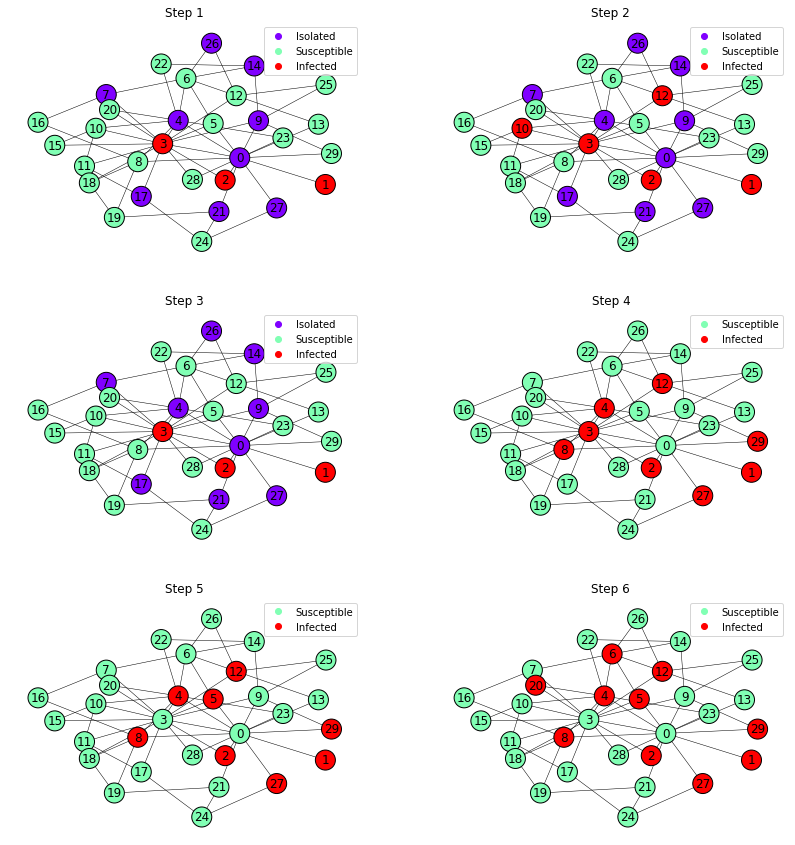

In [41]:
G = nx.barabasi_albert_graph(30, 2, seed=0)
I = np.zeros(len(G))
I[:5] = 1
S = 1 - I
immune_nodes, epidemic = self_isolation_sis(
    G, S, I, share=0.3, period=2, beta=0.2, gamma=0.1, k=6)
plt.figure(figsize=(7*2, 5*3))
pos = nx.kamada_kawai_layout(G)
i = 1
for step, (S, I) in enumerate(epidemic[:6]):
    colors = I + 1
    legend = ['Susceptible', 'Infected']
    if step < 3:
        colors[immune_nodes] = -1
        legend = ['Isolated', 'Susceptible', 'Infected']
    plt.subplot(3, 2, i)
    nodes = nx.draw_networkx_nodes(G, pos, 
            node_size=400,
            node_color=colors, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    nx.draw_networkx_edges(G, pos,
            width=0.5,
            node_size=400)
    nx.draw_networkx_labels(G, pos)
    plt.title('Step {}'.format(i))
    plt.legend(nodes.legend_elements()[0], legend)
    plt.axis('off')
    i += 1

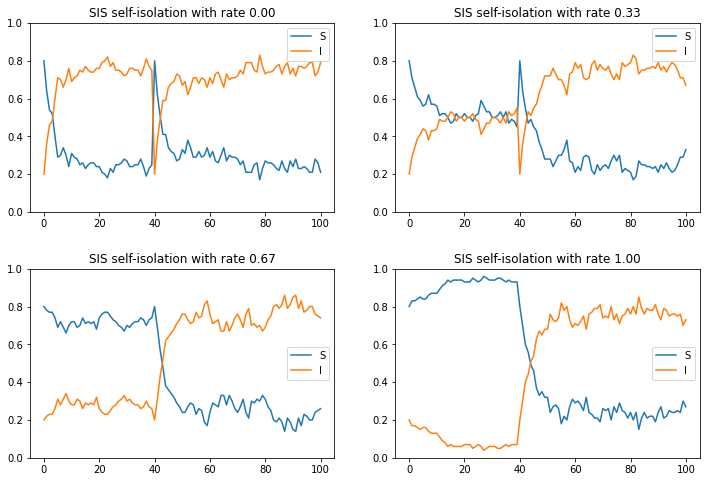

In [42]:
plt.figure(figsize=(6*2, 4*2))
plt.subplots_adjust(hspace=0.3)
G = nx.barabasi_albert_graph(100, 2, seed=0)
I = np.zeros(len(G))
I[:20] = 1
S = 1 - I
i = 1
for share in np.linspace(0, 1, 4):
    plt.subplot(2, 2, i)
    i += 1
    immune, epidemic = self_isolation_sis(
        G, S, I, share, period=40, beta=0.15, gamma=0.1, k=100)
    plt.plot(epidemic.mean(axis=2))
    plt.title(f"SIS self-isolation with rate {share:.2f}")
    plt.legend(['S', 'I'])
    plt.ylim(0, 1)

Here we can see that high self-isolated rate of population delays a case when all people to be infected.

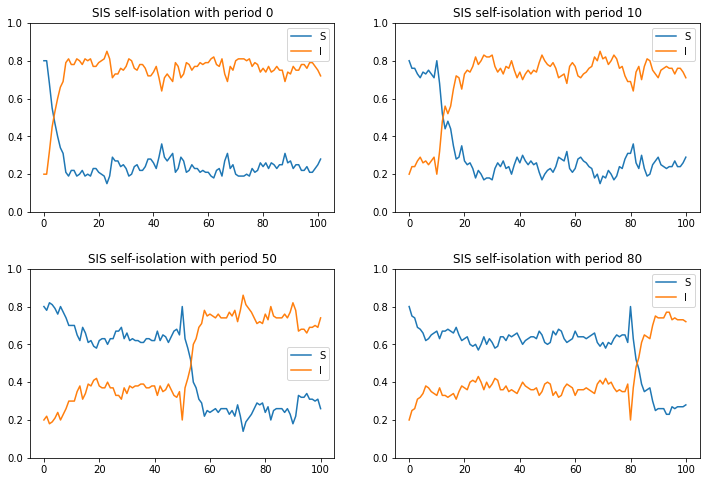

In [43]:
plt.figure(figsize=(6*2, 4*2))
plt.subplots_adjust(hspace=0.3)
G = nx.barabasi_albert_graph(100, 2, seed=0)
I = np.zeros(len(G))
I[:20] = 1
S = 1 - I
i = 1
for period in [0, 10, 50, 80]:
    plt.subplot(2, 2, i)
    i += 1
    immune, epidemic = self_isolation_sis(
        G, S, I, share=0.6, period=period, beta=0.15, gamma=0.1, k=100)
    plt.plot(epidemic.mean(axis=2))
    plt.title(f"SIS self-isolation with period {period}")
    plt.legend(['S', 'I'])
    plt.ylim(0, 1)